# Importacion

In [16]:
from pycocotools.coco import COCO
import os
import shutil
import json
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
from collections import defaultdict

from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models
from torch import optim
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

print("Imports finalizados")



Imports finalizados


# Cargamos las imagenes del subdataset

In [17]:
# output_dir = r"F:\Train_IA\train2017\BalancedDataset"
# annotations_output_path = os.path.join(output_dir, 'annotations/custom_annotations.json')

annotations_output_path = r"F:\Train_IA\train2017\annotations\instances_train2017.json"

In [18]:
# Cargar el nuevo dataset
custom_coco = COCO(annotations_output_path)
totalLabels=0

# Verificar imágenes por categoría
for cat in custom_coco.loadCats(custom_coco.getCatIds()):
    totalLabels+=1
    img_ids = custom_coco.getImgIds(catIds=[cat['id']])
    print(f"Categoría: {cat['name']}, Imágenes: {len(img_ids)}")
    
print(f"\nTotal de categorías: {totalLabels}")

# Verificar que todas las anotaciones tienen una imagen válida
# for ann in custom_coco.loadAnns(custom_coco.getAnnIds()):
#     assert ann['image_id'] in custom_coco.getImgIds(), f"Anotación con imagen inexistente: {ann}"

print("Validación completada: Todas las imágenes y anotaciones son consistentes.")

loading annotations into memory...
Done (t=19.23s)
creating index...
index created!
Categoría: person, Imágenes: 64115
Categoría: bicycle, Imágenes: 3252
Categoría: car, Imágenes: 12251
Categoría: motorcycle, Imágenes: 3502
Categoría: airplane, Imágenes: 2986
Categoría: bus, Imágenes: 3952
Categoría: train, Imágenes: 3588
Categoría: truck, Imágenes: 6127
Categoría: boat, Imágenes: 3025
Categoría: traffic light, Imágenes: 4139
Categoría: fire hydrant, Imágenes: 1711
Categoría: stop sign, Imágenes: 1734
Categoría: parking meter, Imágenes: 705
Categoría: bench, Imágenes: 5570
Categoría: bird, Imágenes: 3237
Categoría: cat, Imágenes: 4114
Categoría: dog, Imágenes: 4385
Categoría: horse, Imágenes: 2941
Categoría: sheep, Imágenes: 1529
Categoría: cow, Imágenes: 1968
Categoría: elephant, Imágenes: 2143
Categoría: bear, Imágenes: 960
Categoría: zebra, Imágenes: 1916
Categoría: giraffe, Imágenes: 2546
Categoría: backpack, Imágenes: 5528
Categoría: umbrella, Imágenes: 3968
Categoría: handbag, Im

In [19]:
# Ruta del archivo de anotaciones y las imágenes del dataset personalizado
#annotations_path = r"F:\Train_IA\train2017\BalancedDataset\annotations\custom_annotations.json"

annotations_path = r"F:\Train_IA\train2017\annotations\instances_train2017.json"

# Cargar las anotaciones del dataset personalizado
coco = COCO(annotations_path)

loading annotations into memory...
Done (t=19.09s)
creating index...
index created!


# Verificacion y configuracion de **CUDAS**

In [20]:
# Verifica si CUDA está disponible
print("CUDA disponible:", torch.cuda.is_available())  # Debería devolver True

# Muestra el dispositivo actual
if torch.cuda.is_available():
    print("Dispositivo actual:", torch.cuda.current_device())
    print("Nombre de la GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA no está disponible.")


CUDA disponible: True
Dispositivo actual: 0
Nombre de la GPU: NVIDIA GeForce RTX 3070 Ti


In [21]:
# Definir los dispositivos (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo actual:", device)
# Cargar el archivo de anotaciones final
annotations_path = r"F:\Train_IA\train2017\annotations\instances_train2017.json"
coco = COCO(annotations_path)

# Obtener las categorías y asignarlas a un índice
categories = coco.loadCats(coco.getCatIds())
category_names = {cat['id']: cat['name'] for cat in categories}

# Cargar las imágenes y sus anotaciones
image_ids = coco.getImgIds()
images_info = coco.loadImgs(image_ids)

# Definir las transformaciones para el preprocesamiento de las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir la imagen a un tensor
    transforms.Resize((224, 224)),  # Redimensionar las imágenes a 224x224
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar
])

# Función para cargar las anotaciones
def load_annotations(img_id):
    ann_ids = coco.getAnnIds(imgIds=[img_id])
    annotations = coco.loadAnns(ann_ids)
    labels = [ann['category_id'] for ann in annotations]
    
    # Filtrar las etiquetas para que estén dentro del rango de las categorías disponibles
    valid_labels = [label - 1 for label in labels if 1 <= label <= len(categories)]
    
    return valid_labels

# Crear un Dataset para PyTorch
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, coco, images_info, categories, transform=None):
        self.coco = coco
        self.images_info = images_info
        self.categories = categories
        self.transform = transform
        
    def __len__(self):
        return len(self.images_info)
    
    def __getitem__(self, idx):
        img_info = self.images_info[idx]
        img_id = img_info['id']
        img_path = os.path.join('F:/Train_IA/train2017/train2017', img_info['file_name'])
        
        image = datasets.folder.default_loader(img_path)  # Cargar la imagen
        if self.transform:
            image = self.transform(image)  # Aplicar las transformaciones
        
        labels = load_annotations(img_id)  # Obtener las etiquetas para la imagen
        labels_tensor = torch.zeros(len(self.categories))  # Crear un tensor para las etiquetas
        
        # Marcar las posiciones correspondientes en el tensor de etiquetas
        for label in labels:
            labels_tensor[label] = 1  # Marcar la categoría correspondiente
        
        return image, labels_tensor

# Crear el DataLoader
dataset = CocoDataset(coco, images_info, categories, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Dispositivo actual:

 cuda
loading annotations into memory...
Done (t=25.45s)
creating index...
index created!


# Cargamos la arquitectura de la red neuronal

In [22]:
#from torchvision.models import ResNet18_Weights

from torchvision.models import ResNet50_Weights

In [23]:
# # Cargar una arquitectura modelo (ResNet-18)
# model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Cargar una arquitectura modelo (ResNet-18)
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

In [24]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
class MLC(nn.Module):
    def __init__(self, num_classes):
        super(MLC, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(self.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x


# Ponemos el numero de categorias de salida

In [26]:
print(len(categories))
model = MLC(num_classes=len(categories))
model.resnet

80


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Creacion del entrenamiento

In [27]:
# Función de pérdida para multilabel
criterion = nn.BCEWithLogitsLoss()

# Optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [28]:
# Mover el modelo a la GPU
model = model.to(device)

In [29]:
import time

In [30]:
num_epochs = 15

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        
        # Poner los gradientes a cero
        optimizer.zero_grad()
        
        # Realizar la inferencia
        outputs = model(inputs)
        
        # Calcular la pérdida
        loss = criterion(outputs, labels.float())
        
        # Retropropagación
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    elapsed_time = time.time() - start_time
        

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}, Time: {elapsed_time:.2f} seconds")


Epoch [1/15], Loss: 0.0692796520939188, Time: 1690.03 seconds
Epoch [2/15], Loss: 0.05704038324474901, Time: 1630.58 seconds
Epoch [3/15], Loss: 0.050802521251921945, Time: 1606.00 seconds
Epoch [4/15], Loss: 0.045199253507943966, Time: 1592.83 seconds
Epoch [5/15], Loss: 0.03991692624371504, Time: 1603.19 seconds
Epoch [6/15], Loss: 0.03440037147540771, Time: 1652.31 seconds
Epoch [7/15], Loss: 0.02890303150279871, Time: 1633.14 seconds
Epoch [8/15], Loss: 0.023586391471830177, Time: 1597.48 seconds
Epoch [9/15], Loss: 0.018782567179441646, Time: 1601.97 seconds
Epoch [10/15], Loss: 0.014920921530322647, Time: 1631.26 seconds
Epoch [11/15], Loss: 0.01203818670276241, Time: 1596.68 seconds
Epoch [12/15], Loss: 0.010068774913506436, Time: 1593.56 seconds
Epoch [13/15], Loss: 0.008718283545686356, Time: 1600.97 seconds
Epoch [14/15], Loss: 0.007893380250038379, Time: 1683.98 seconds
Epoch [15/15], Loss: 0.007038964823123661, Time: 1645.50 seconds


# Guardar los pesos

In [31]:
# Guardar los pesos al final del entrenamiento
model_path = "modelo_pesos1.pth"
torch.save(model.state_dict(), model_path)
print(f"Pesos del modelo guardados en {model_path}")

Pesos del modelo guardados en modelo_pesos1.pth


In [32]:
# Crear un mapeo de índice a ID de categoría
id_to_index = {cat['id']: i for i, cat in enumerate(categories)}  # De COCO ID a índice
index_to_id = {v: k for k, v in id_to_index.items()}  # De índice a COCO ID
category_names = {cat['id']: cat['name'] for cat in categories}  # De COCO ID a nombre


print("Mapping de IDs a índices (id_to_index):")
print(id_to_index)

print("\nMapping de índices a IDs (index_to_id):")
print(index_to_id)

print("\nNombres de las categorías (category_names):")
print(category_names)

Mapping de IDs a índices (id_to_index):
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19, 22: 20, 23: 21, 24: 22, 25: 23, 27: 24, 28: 25, 31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39, 46: 40, 47: 41, 48: 42, 49: 43, 50: 44, 51: 45, 52: 46, 53: 47, 54: 48, 55: 49, 56: 50, 57: 51, 58: 52, 59: 53, 60: 54, 61: 55, 62: 56, 63: 57, 64: 58, 65: 59, 67: 60, 70: 61, 72: 62, 73: 63, 74: 64, 75: 65, 76: 66, 77: 67, 78: 68, 79: 69, 80: 70, 81: 71, 82: 72, 84: 73, 85: 74, 86: 75, 87: 76, 88: 77, 89: 78, 90: 79}

Mapping de índices a IDs (index_to_id):
{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 13, 12: 14, 13: 15, 14: 16, 15: 17, 16: 18, 17: 19, 18: 20, 19: 21, 20: 22, 21: 23, 22: 24, 23: 25, 24: 27, 25: 28, 26: 31, 27: 32, 28: 33, 29: 34, 30: 35, 31: 36, 32: 37, 33: 38, 34: 39, 35: 40, 36: 41, 37: 42, 38: 43, 39:

# Prediccion de imagenes

In [33]:
def predict(image_path, model, coco):
    model.eval()  # Poner el modelo en modo evaluación
    image = datasets.folder.default_loader(image_path)
    image = transform(image).unsqueeze(0).to(device)  # Aplicar transformaciones
    
    with torch.no_grad():
        outputs = model(image)
        
    # Aplicar sigmoid para obtener probabilidades
    probs = torch.sigmoid(outputs).cpu().numpy()
    
    # Obtener los índices predichos (según el mapeo del modelo)
    predicted_indices = [i for i, p in enumerate(probs[0]) if p > 0.5]
    
    # Convertir índices a IDs de categoría
    predicted_ids = [index_to_id[i] for i in predicted_indices]
    
    # Obtener los nombres de las categorías
    labels = [category_names[cat_id] for cat_id in predicted_ids]
    
    return labels



In [34]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_show(image_path, model, coco):
    model.eval()  # Poner el modelo en modo evaluación
    image = datasets.folder.default_loader(image_path)  # Cargar la imagen
    image_transformed = transform(image).unsqueeze(0).to(device)  # Aplicar transformaciones
    
    with torch.no_grad():
        outputs = model(image_transformed)  # Inferencia
        
    # Aplicar sigmoid para obtener probabilidades
    probs = torch.sigmoid(outputs).cpu().numpy()
    
    # Obtener los índices predichos (según el mapeo del modelo)
    predicted_indices = [i for i, p in enumerate(probs[0]) if p > 0.5]
    
    # Convertir índices a IDs de categoría (usando el mapeo index_to_id)
    predicted_ids = [index_to_id[i] for i in predicted_indices]
    
    # Obtener los nombres de las categorías
    labels = [category_names[cat_id] for cat_id in predicted_ids]
    
    # Mostrar la imagen con las etiquetas predichas
    plt.figure(figsize=(8, 8))
    plt.imshow(image)  # Mostrar la imagen
    plt.axis('off')  # Quitar ejes
    plt.title(f"Predicciones: {', '.join(labels)}", fontsize=12)  # Agregar las etiquetas como título
    plt.show()
    
    return labels


In [35]:
image_path = r"C:\Users\Juanja Malo\Pictures\images.jpeg"  # Cambia a la ruta de tu imagen
predicted_labels = predict_and_show(image_path, model, coco)
print("Etiquetas predichas:")
print(predicted_labels)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Juanja Malo\\Pictures\\images.jpeg'

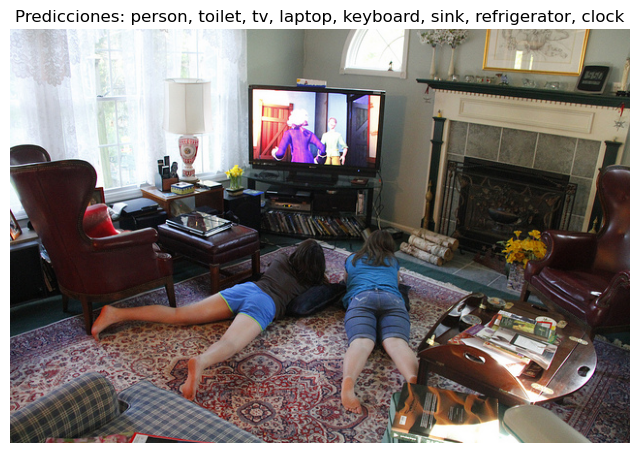

Etiquetas predichas:
['person', 'toilet', 'tv', 'laptop', 'keyboard', 'sink', 'refrigerator', 'clock']


In [36]:
image_path = "F:/Train_IA/train2017/train2017/000000422969.jpg"  # Cambia a la ruta de tu imagen
predicted_labels = predict_and_show(image_path, model, coco)
print("Etiquetas predichas:")
print(predicted_labels)

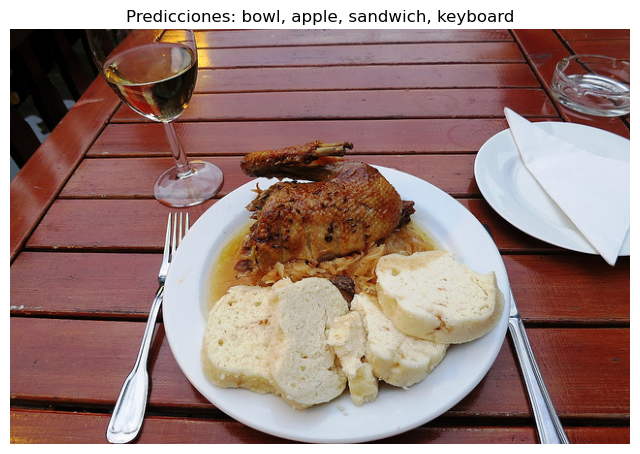

Etiquetas predichas:
['bowl', 'apple', 'sandwich', 'keyboard']


In [ ]:
image_path = "F:/Train_IA/train2017/train2017/000000400347.jpg"  # Cambia a la ruta de tu imagen
predicted_labels = predict_and_show(image_path, model, coco)
print("Etiquetas predichas:")
print(predicted_labels)

# Medidas de Calidad

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluar el modelo
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images, labels = images.cuda(), labels.cuda() if torch.cuda.is_available() else (images, labels)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convertir listas a arrays numpy
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

100%|██████████| 3697/3697 [25:58<00:00,  2.37it/s]
f:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
f:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8974
Precision: 0.8753
Recall: 0.8581
F1 Score: 0.8663


f:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
